## Passing workflows between functions

Demo to use workflows in functions

In [1]:
from napari_workflows import Workflow
import pyclesperanto_prototype as cle
import numpy as np
from skimage.io import imread
from tqdm import tqdm 
import dask.array as da

import matplotlib.pyplot as plt

C:\Users\Pradeep\.conda\envs\napari-lattice\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
img = imread("../sample_data/RBC_lattice.tif")

voxel_size_x_in_microns = 0.145
voxel_size_y_in_microns = 0.145
voxel_size_z_in_microns = 0.3
deskewing_angle_in_degrees = 30

In [3]:
img.shape

(150, 118, 209)

In [4]:
deskew_workflow = Workflow()

#define deskewing workflow
#save it
input_arg = "input"
task_name = "deskewing"
deskew_workflow.set(task_name, cle.deskew_y, input_arg, angle_in_degrees = deskewing_angle_in_degrees,
                    voxel_size_x = voxel_size_x_in_microns, voxel_size_y= voxel_size_y_in_microns,
                    voxel_size_z = voxel_size_z_in_microns)


print(deskew_workflow)

Workflow:
deskewing <- (<function deskew_y at 0x00000172A0F86670>, 'input', None, 30, 0.145, 0.145, 0.3, 1)



#### Idea is to pass a workflow, workflow name and argument to be set to a function that can then do a task

In [5]:
def save_img(vol,
              workflow:Workflow,
              input_arg,
              task_name
              ):         
    
    workflow.set(input_arg, vol)
    im = workflow.get(task_name)
    return im

deskewed = save_img(vol = img, 
                     workflow = deskew_workflow, 
                     input_arg = input_arg,
                     task_name = task_name)
deskewed.shape

(59, 416, 209)

### Save a file

Define a function that
* takes workflow and nd array
* goes through each timepoint
* Perform workflow on each 3D volume
* saves processed file

In [6]:
#Lets create a 5D array with 3 timepoints and 1 channel
#Aicsimageio returns objects as TCZYX, so we'll follow that format

#Use existing dataset to add a channel
multi_ch = np.expand_dims(img, axis = 0)
#Stack thrice to create 3 timepoints
img_arr = np.stack((multi_ch,multi_ch,multi_ch))
img_arr.shape

(3, 1, 150, 118, 209)

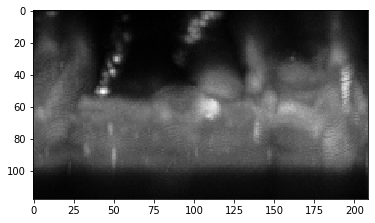

In [7]:
cle.imshow(cle.maximum_z_projection(img_arr[0,0,...]))

In [8]:
from pathlib import Path

#We pass a workflow and the argument we used for defining the input volume
#The input volume is going to be a subset of "vol" as defined by time and channel

def save_tiff(vol,
              workflow:Workflow,
              input_arg,
              task_name,
              time_start:int = 0,
              time_end:int = 1,
              channel_start:int = 0,
              channel_end:int = 1,
              save_path:Path = Path.home(),
              save_name_prefix:str = "",
              save_name:str = "img",
              dx:float = 1,
              dy:float = 1,
              dz:float = 1):
    """
    Processes files based on a workflow 
    Applies that to an image in  each channel and timepoint
    Saves the images

    vol is potentially a 5D array
    """              
    
    save_path = save_path.__str__()

    #Define time and channel ranges
    time_range = range(time_start, time_end)
    channel_range = range(channel_start, channel_end)
    
    #loop through each time point and channel
    for time_point in tqdm(time_range, desc="Time", position=0):
        images_array = []      
        for ch in tqdm(channel_range, desc="Channels", position=1,leave=False):
            
            #Extract 3D volume
            if len(vol.shape) == 3:
                raw_vol = vol
            else:
                raw_vol = vol[time_point, ch, :, :, :]
            
            #Set the input argument
            workflow.set(input_arg, raw_vol)

            #Execute workflow
            processed_vol = workflow.get(task_name)
            
            print(processed_vol.shape)
            #fig,axes = plt.subplots(1,1, figsize=(30,20))
            cle.imshow(cle.maximum_z_projection(processed_vol), colormap ="nipy_spectral" )
            
            images_array.append(processed_vol)
            
        images_array = np.array(images_array)
        final_name = save_path + os.sep +save_name_prefix+ "C" + str(ch) + "T" + str(
                        time_point) + "_" + save_name + ".ome.tif"

        
        print("Saving file at T ",time_point," and channel ",ch)

        #Disabling save for now to demonstrate the above point
        ##OmeTiffWriter.save(images_array, final_name, physical_pixel_sizes=aics_image_pixel_sizes)
    
    return


We can further pass a complex workflow into a function

In [9]:
import random 


image_seg_workflow = Workflow()
input_arg = "input"
image_seg_workflow.set("deskewing", cle.deskew_y, input_arg, angle_in_degrees = deskewing_angle_in_degrees,
                    voxel_size_x = voxel_size_x_in_microns, voxel_size_y= voxel_size_y_in_microns,
                    voxel_size_z = voxel_size_z_in_microns)

image_seg_workflow.set("median", cle.median_sphere,"deskewing",radius_x = 2, radius_y = 2, radius_z = 2)

image_seg_workflow.set("binarisation", cle.threshold,"median",constant =1000)

image_seg_workflow.set("labeling", cle.connected_components_labeling_box,"binarisation")

print(str(image_seg_workflow))

Workflow:
deskewing <- (<function deskew_y at 0x00000172A0F86670>, 'input', None, 30, 0.145, 0.145, 0.3, 1)
median <- (<function median_sphere at 0x00000172A0C26790>, 'deskewing', None, 2, 2, 2)
binarisation <- (<function greater_constant at 0x00000172A0C0BC10>, 'median', None, 1000)
labeling <- (<function connected_components_labeling_box at 0x00000172A0CC5A60>, 'binarisation')



Time:   0%|          | 0/3 [00:00<?, ?it/s]

(59, 416, 209)


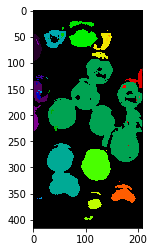

Time:  33%|███▎      | 1/3 [00:00<00:00,  2.54it/s]

Saving file at T  0  and channel  0


(59, 416, 209)


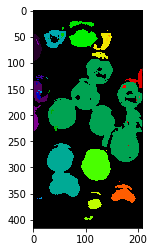

Time:  67%|██████▋   | 2/3 [00:00<00:00,  2.69it/s]

Saving file at T  1  and channel  0


(59, 416, 209)


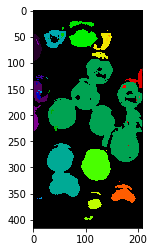

Time: 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]

Saving file at T  2  and channel  0


In [10]:
task_name_execute = "labeling"

t1 = 0
t2 = 3

save_tiff(vol = img_arr, workflow = image_seg_workflow, input_arg = input_arg, 
         task_name = task_name_execute, time_start = t1,time_end = t2,save_path =Path.home(),
        dx = voxel_size_x_in_microns,dy = voxel_size_y_in_microns, dz = voxel_size_z_in_microns )